### Import Libraries

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import re

import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer

# nltk.download('wordnet')
# nltk.download('omw-1.4')

from textblob import TextBlob

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.metrics import classification_report, accuracy_score, ConfusionMatrixDisplay

from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.naive_bayes import MultinomialNB, GaussianNB

from wordcloud import WordCloud

STOPWORDS = set(stopwords.words('english'))

### Load Datasets
Integrating datasets into two data frames, True and False

In [2]:
dfFake = pd.read_csv('Data/archive/Fake.csv')
dfFake['label'] = 'Fake'
del dfFake['subject']
del dfFake['date']

dfFake

,title,text,label
0,Donald Trump Sends Out Embarrassing New Year’...,Donald Trump just couldn t wish all Americans ...,Fake
1,Drunk Bragging Trump Staffer Started Russian ...,House Intelligence Committee Chairman Devin Nu...,Fake
2,Sheriff David Clarke Becomes An Internet Joke...,"On Friday, it was revealed that former Milwauk...",Fake
3,Trump Is So Obsessed He Even Has Obama’s Name...,"On Christmas day, Donald Trump announced that ...",Fake
4,Pope Francis Just Called Out Donald Trump Dur...,Pope Francis used his annual Christmas Day mes...,Fake
...,...,...,...
23476,McPain: John McCain Furious That Iran Treated ...,21st Century Wire says As 21WIRE reported earl...,Fake
23477,JUSTICE? Yahoo Settles E-mail Privacy Class-ac...,21st Century Wire says It s a familiar theme. ...,Fake
23478,Sunnistan: US and Allied ‘Safe Zone’ Plan to T...,Patrick Henningsen 21st Century WireRemember ...,Fake
23479,How to Blow $700 Million: Al Jazeera America F...,21st Century Wire says Al Jazeera America will...,Fake


In [3]:
dfTrue = pd.read_csv('Data/archive/True.csv')
dfTrue['label'] = 'True'
del dfTrue['subject']
del dfTrue['date']

dfTrue

,title,text,label
0,"As U.S. budget fight looms, Republicans flip t...",WASHINGTON (Reuters) - The head of a conservat...,True
1,U.S. military to accept transgender recruits o...,WASHINGTON (Reuters) - Transgender people will...,True
2,Senior U.S. Republican senator: 'Let Mr. Muell...,WASHINGTON (Reuters) - The special counsel inv...,True
3,FBI Russia probe helped by Australian diplomat...,WASHINGTON (Reuters) - Trump campaign adviser ...,True
4,Trump wants Postal Service to charge 'much mor...,SEATTLE/WASHINGTON (Reuters) - President Donal...,True
...,...,...,...
21412,'Fully committed' NATO backs new U.S. approach...,BRUSSELS (Reuters) - NATO allies on Tuesday we...,True
21413,LexisNexis withdrew two products from Chinese ...,"LONDON (Reuters) - LexisNexis, a provider of l...",True
21414,Minsk cultural hub becomes haven from authorities,MINSK (Reuters) - In the shadow of disused Sov...,True
21415,Vatican upbeat on possibility of Pope Francis ...,MOSCOW (Reuters) - Vatican Secretary of State ...,True


#### Modified data quality report
Helps determine what cleaning needs to be done

In [4]:
def quality_report(df):
  # Constructing a data quality report for the data
  cat_data = {'Feature': ['title', 'text', 'label'],
              'Count': df.count(),
              '% Missing': df.isnull().sum() * 100 / len(df),
              'Cardinality': df.apply(pd.Series.nunique),
              'Mode': [df.mode()['title'][0], 'null', df.mode()['label'][0]],
              'Mode Freq.': ['14', '769', '39644'],
              'Mode %': [14 / 63552 * 100, 769 / 64186 * 100 , 39644 / 64232 * 100],
      
              'Notes': ['', '', '']}
  cat_dqr_df = pd.DataFrame(cat_data)
  cat_dqr_df.reset_index(drop=True, inplace=True)

  return cat_dqr_df

In [5]:
print("Quality Report True Dataset")
quality_report(dfTrue).head()


Quality Report True Dataset


,Feature,Count,% Missing,Cardinality,Mode,Mode Freq.,Mode %,Notes
0,title,21417,0.0,20826,Factbox: Trump fills top jobs for his administ...,14,0.022029,
1,text,21417,0.0,21192,null,769,1.198081,
2,label,21417,0.0,1,True,39644,61.720015,


In [6]:
print("Quality Report Fake Dataset")
quality_report(dfFake).head()

Quality Report Fake Dataset


,Feature,Count,% Missing,Cardinality,Mode,Mode Freq.,Mode %,Notes
0,title,23481,0.0,17903,MEDIA IGNORES Time That Bill Clinton FIRED His...,14,0.022029,
1,text,23481,0.0,17455,null,769,1.198081,
2,label,23481,0.0,1,Fake,39644,61.720015,


In [7]:
# Build project using 20% 
dfTrue = dfTrue.head(int(0.40 * dfTrue.shape[0]))
dfFake = dfFake.head(int(0.40 * dfFake.shape[0]))

### Data Preprocessing
Removing stopwords, punctuation, and whitespace characters and Stemming

In [8]:
def clean_string(input):
  wl = WordNetLemmatizer()
  
  input = re.sub('[^a-zA-Z]', ' ', input)  # Remove special characters and spaces
  input = input.lower()                    # Lowercase all text

  input = input.split()  # Seperate into array of words
  input = [wl.lemmatize(word) for word in input if not word in STOPWORDS] # Remove stop words and replace word with stem
  input = ' '.join(input)  # Combine back into sentence             
  
  return input

def preprocess(df):
  copy = df.copy()
  copy.drop_duplicates(inplace = True) # Remove duplicates
  copy.dropna(axis=0, inplace = True)  # Remove rows with missing values
  cleanfunc = np.vectorize(clean_string)    # Use vectorization to increase speed
  copy['title'] = cleanfunc(copy['title'])  # Clean titles
  copy['text'] = cleanfunc(copy['text'])    # Clean text 
  return copy

In [9]:
dfTrue = preprocess(dfTrue)
dfFake = preprocess(dfFake)

In [10]:
dfTrue.head()

,title,text,label
0,u budget fight loom republican flip fiscal script,washington reuters head conservative republica...,True
1,u military accept transgender recruit monday p...,washington reuters transgender people allowed ...,True
2,senior u republican senator let mr mueller job,washington reuters special counsel investigati...,True
3,fbi russia probe helped australian diplomat ti...,washington reuters trump campaign adviser geor...,True
4,trump want postal service charge much amazon s...,seattle washington reuters president donald tr...,True


In [11]:
dfFake.head()

,title,text,label
0,donald trump sends embarrassing new year eve m...,donald trump wish american happy new year leav...,Fake
1,drunk bragging trump staffer started russian c...,house intelligence committee chairman devin nu...,Fake
2,sheriff david clarke becomes internet joke thr...,friday revealed former milwaukee sheriff david...,Fake
3,trump obsessed even obama name coded website i...,christmas day donald trump announced would bac...,Fake
4,pope francis called donald trump christmas speech,pope francis used annual christmas day message...,Fake


### Data Exploration & Visualization

#### Character Count in Title and Text

In [12]:
# Returns the char count for specified field
def getCharCount(df, field):
  return [len(text) for text in df[field].to_list()]

# Visualize char count of field in histogram
def histogram_char_count(df, count, field, label):
  plt.hist(count)
  plt.xlabel("Characters")
  plt.ylabel("News")
  plt.title(f'Character Count Distribution of {field} in {label} News')
  plt.show()

def plot_avg_char_count(dfTrue, dfFake, field, countTrue, countFake):
  avg_count_true = int(np.average(countTrue))
  avg_count_fake = int(np.mean(countFake))

  df = pd.DataFrame([['True', int(avg_count_true)], ['Fake', int(avg_count_fake)]], columns=['News', 'Characters'])
  df.plot(x='News', y='Characters', kind='bar', width=0.3, xlabel='News', legend=False,
                    ylabel='Characters', title=f'Average Character Count of {field}')  
  plt.xticks(rotation=0)
  plt.show()
  
# Calculate and visualize character count statistics
def character_stats(dfTrue, dfFake, field):
  print(f"Character Count Distribution of {field}")
  true_char_count= getCharCount(dfTrue, field)
  histogram_char_count(dfTrue, true_char_count, field, "True")

  fake_char_count = getCharCount(dfFake, field)
  histogram_char_count(dfFake, fake_char_count, field, "Fake") 

  print(f"Average Count of {field}")
  plot_avg_char_count(dfTrue, dfFake, field, true_char_count, fake_char_count)

Character Count Distribution of title


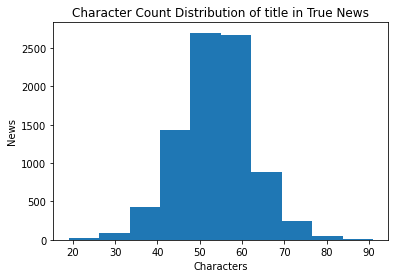

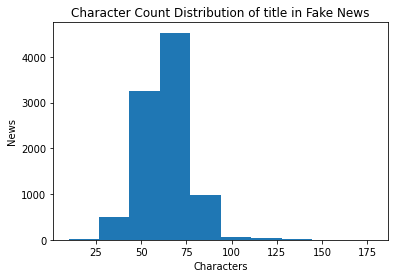

Average Count of title


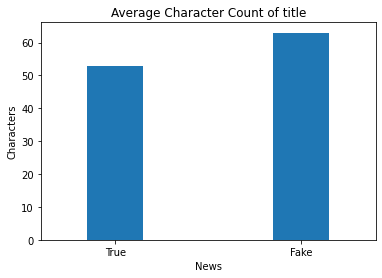

Character Count Distribution of text


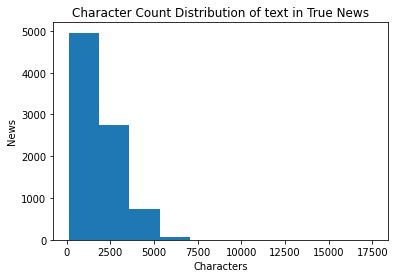

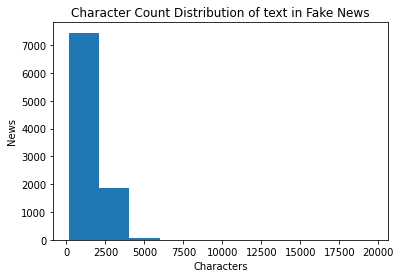

Average Count of text


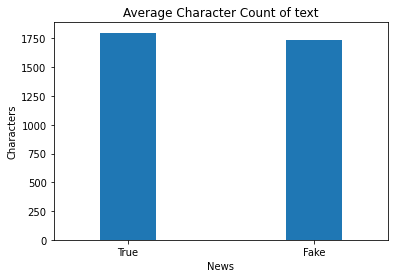

In [13]:
character_stats(dfTrue, dfFake, 'title')
character_stats(dfTrue, dfFake, 'text')

#### Word count in Title and Text

In [14]:
vectorizer = CountVectorizer()

# Returns the char count for specified field
def getWordCount(df, field):
  counts = []
  for text in df[field].to_list():
    text_count = np.sum(vectorizer.fit_transform([text]).toarray())
    counts.append(text_count)
  return counts

# Visualize word count of field in histogram
def histogram_word_count(df, count, field, label):
  plt.hist(count)
  plt.xlabel("Words")
  plt.ylabel("News")
  plt.title(f'Word Count Distribution of {field} in {label} News')
  plt.show()
  
def plot_avg_word_count(dfTrue, dfFake, field, countTrue, countFake):
  avg_count_true = int(np.average(countTrue))
  avg_count_fake = int(np.mean(countFake))

  df = pd.DataFrame([['True', int(avg_count_true)], ['Fake', int(avg_count_fake)]], columns=['News', 'Words'])
  df.plot(x='News', y='Words', kind='bar', width=0.3, xlabel='News', legend=False,
                    ylabel='Words', title=f'Average Word Count of {field}')  
  plt.xticks(rotation=0)
  plt.show()
  
# Calculate and visualize word count statistics
def word_stats(dfTrue, dfFake, field):
  print(f"Word Count Distribution of {field}")
  true_word_count= getWordCount(dfTrue, field)
  histogram_word_count(dfTrue, true_word_count, field, "True")

  fake_word_count = getWordCount(dfFake, field)
  histogram_word_count(dfFake, fake_word_count, field, "Fake") 

  print(f"Average count of {field}")
  plot_avg_word_count(dfTrue, dfFake, field, true_word_count, fake_word_count)


Word Count Distribution of title


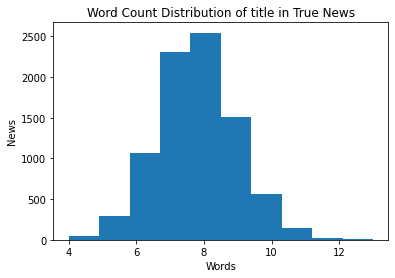

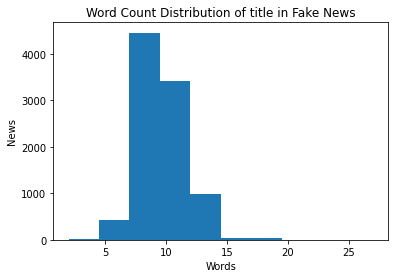

Average count of title


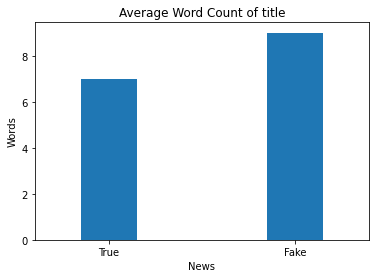

In [15]:
word_stats(dfTrue, dfFake, 'title')

Word Count Distribution of text


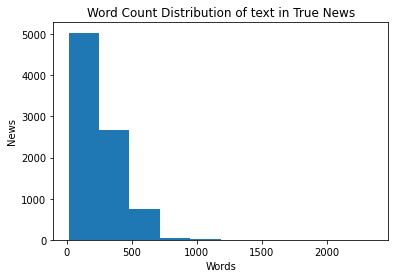

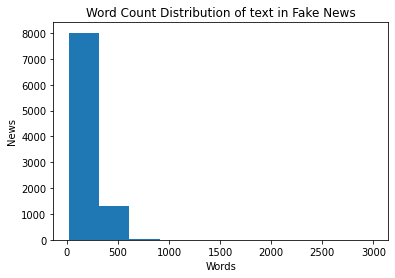

Average count of text


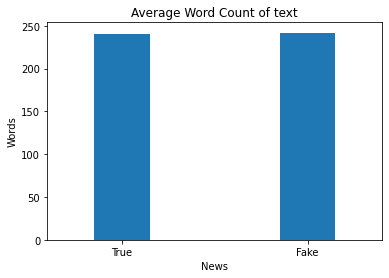

In [16]:
word_stats(dfTrue, dfFake, 'text')

#### Visualize Frequent Words with WordCloud

In [17]:
def generateWordCloud(df, feature):
  wordcloud = WordCloud(max_words=50).generate(' '.join(df[feature].tolist()))
  # plot the WordCloud                      
  plt.figure(figsize = (10, 10), facecolor = None)
  plt.imshow(wordcloud)
  plt.axis("off")
  plt.tight_layout(pad = 0)
  
  plt.show()


WordCloud for Fake News Titles


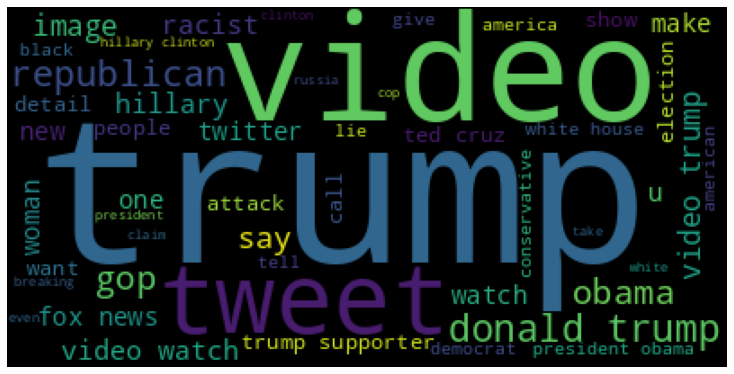

WordCloud for Fake News Text


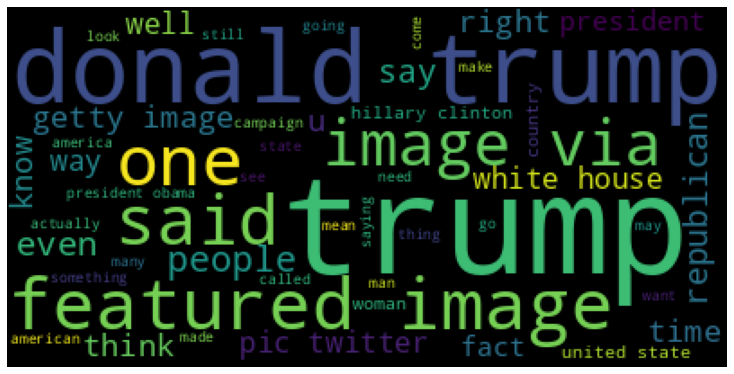

In [18]:
# Visualize most significant words for fake news
print("WordCloud for Fake News Titles")
generateWordCloud(dfFake, 'title')
print("WordCloud for Fake News Text")
generateWordCloud(dfFake, 'text')

WordCloud for True News Titles


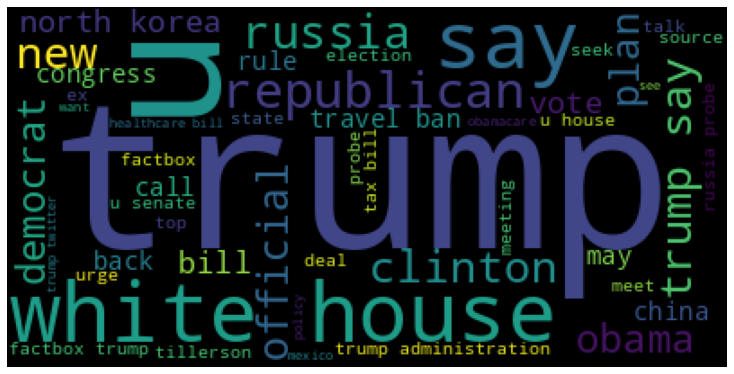

WordCloud for True News Text


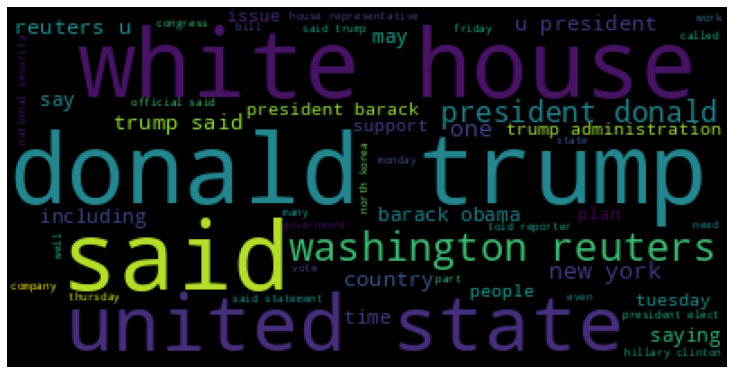

In [19]:
# Visualize most significant words for true news
print("WordCloud for True News Titles")
generateWordCloud(dfTrue, 'title')
print("WordCloud for True News Text")
generateWordCloud(dfTrue, 'text')

#### Sentiment Analysis

In [20]:
def plot_polarity(field):
  true_polarities = dfTrue[field].map(lambda text: TextBlob(text).sentiment.polarity)
  fake_polarities = dfFake[field].map(lambda text: TextBlob(text).sentiment.polarity)

  avg_true_polarity = np.average(true_polarities)
  avg_fake_polarity = np.average(fake_polarities)

  print(f'Average polarity of True {field}: {avg_true_polarity:.4f}')
  print(f'Average polarity of Fake {field}: {avg_fake_polarity:.4f}')


  df = pd.DataFrame([['True', avg_true_polarity], ['Fake', avg_fake_polarity]], columns=['News', 'Polarity'])
  df.plot(x='News', y='Polarity', kind='bar', width=0.3, xlabel='News', legend=False,
                    ylabel='Words', title=f'Average Polarity of {field}')  
  plt.xticks(rotation=0)
  plt.show()



def plot_subjectivity(field):
  true_subjectivity = dfTrue[field].map(lambda text: TextBlob(text).sentiment.subjectivity)
  fake_subjectivity = dfFake[field].map(lambda text: TextBlob(text).sentiment.subjectivity)

  avg_true_subjectivity = np.average(true_subjectivity)
  avg_fake_subjectivity = np.average(fake_subjectivity)

  print(f'Average subjectivity of True {field}: {avg_true_subjectivity:.4f}')
  print(f'Average subjectivity of Fake {field}: {avg_fake_subjectivity:.4f}')


  df = pd.DataFrame([['True', avg_true_subjectivity], ['Fake', avg_fake_subjectivity]], columns=['News', 'Subjectivity'])
  df.plot(x='News', y='Subjectivity', kind='bar', width=0.3, xlabel='News', legend=False,
                    ylabel='Words', title=f'Average Subjectivity of {field}')  
  plt.xticks(rotation=0)
  plt.show()

##### Average Polarity of Titles

Average polarity of True title: 0.0326
Average polarity of Fake title: -0.0024


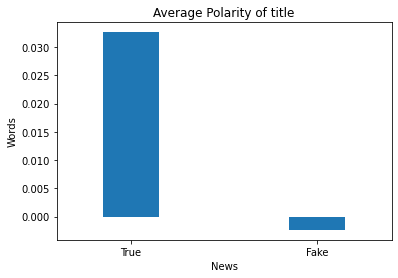

In [21]:
plot_polarity('title')

##### Average Polarity of Texts

Average polarity of True text: 0.0658
Average polarity of Fake text: 0.0425


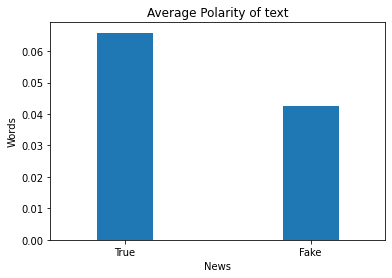

In [22]:
plot_polarity('text')

##### Average Subjectivity of Titles

Average subjectivity of True title: 0.1836
Average subjectivity of Fake title: 0.3740


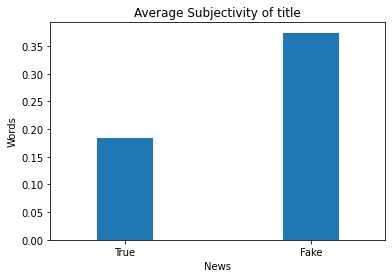

In [23]:
plot_subjectivity('title')

##### Average Subjectivity of Texts

Average subjectivity of True text: 0.3661
Average subjectivity of Fake text: 0.4592


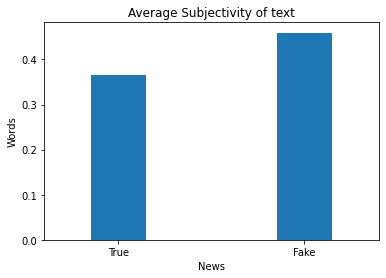

In [24]:
plot_subjectivity('text')

### Classifications

#### Combine Text and Title

In [25]:
def combine_text_title(df, label):
  newdf = pd.DataFrame()
  content = zip(df['title'].to_list(), df['text'].to_list())
  newdf['content'] = [str(title + text) for title, text in content]
  newdf['label'] = [ label for i in range(df.shape[0]) ]  # Add label
  return newdf

In [26]:
dfFake = combine_text_title(dfFake, 'Fake')
dfTrue = combine_text_title(dfTrue, 'True')

#### Create Train and Test Sets

In [27]:
dataset = pd.concat([dfTrue, dfFake]) # Combine True and Fake datasets 
train_set, test_set = train_test_split(dataset, train_size=0.7)
train_set.reset_index(drop=True)
test_set.reset_index(drop=True)

,content,label
0,like kumbaya trump genial private meeting ceo ...,True
1,watch found donald trump campaign theme song v...,Fake
2,u taxpayer rush claim deduction threat tax bil...,True
3,house republican went retirement saving want g...,Fake
4,leading democrat say equifax gave consumer con...,True
...,...,...
5369,paul ryan challenge start nov electionwashingt...,True
5370,parent unhappy new jersey high school removal ...,Fake
5371,hillary clinton real record lgbt righthillary ...,Fake
5372,esurance win april fool day hilarious dig year...,Fake


#### Create Different Term Vector Models


In [28]:
# Create specified vector model using vectorizer
def create_vector_model(vectorizer, train_set, test_set):
  cpy_train_set = train_set.copy()
  cpy_test_set = test_set.copy()

  train_labels = cpy_train_set['label']
  test_labels = cpy_test_set['label']

  le = LabelEncoder()
  le.fit(['Fake', "True"])
  train_labels = le.fit_transform(train_labels)
  test_labels = le.fit_transform(test_labels)

  cpy_train_set.drop(columns='label', inplace=True)
  cpy_test_set.drop(columns='label', inplace=True)



  cpy_train_set = vectorizer.fit_transform(cpy_train_set['content'])
  cpy_test_set = vectorizer.transform(cpy_test_set['content'])


  return cpy_train_set, train_labels, cpy_test_set, test_labels

Simple Count Vector Model

In [29]:
# Create simple count vector model of dataset
count_v = CountVectorizer()
count_vector_model = create_vector_model(count_v, train_set, test_set)

cv_train_set = count_vector_model[0]
cv_test_set = count_vector_model[2]


TF-IDF Vector Model

In [30]:
# Create TF-IDF vector model of dataset
tfidf_v = TfidfVectorizer(max_features=5000, ngram_range=(1,3))  # Get 5000 most significant words/n-grams
tfidf_vector_model = create_vector_model(tfidf_v, train_set, test_set)

In [31]:
tv_train_set, tv_train_labels, tv_test_set, tv_test_labels = tfidf_vector_model


#### Classfication Methods

In [32]:
# Apply specified classification method and provide performance metrics
def classify_pipeline(method, vector_model, report = True, to_arr = False):
  train_set, train_labels, test_set, test_labels = vector_model # Get sets and labels from model

  if to_arr:
      train_set = train_set.toarray()
      test_set = test_set.toarray()


  scl = StandardScaler(with_mean=False).fit(train_set)
  model = method.fit(train_set, train_labels)
  
  pipeline = Pipeline([('scl', scl), ('model', model)])  # Pipeline standardize data then use given classification method
  
  predictions = pipeline.predict(test_set)

  cr = classification_report(test_labels, predictions)
  accuracy = accuracy_score(test_labels, predictions)

  if report:
    print(cr)
    print(f'Accuracy: {accuracy*100:.3f} %')
    print(f"Confusion Matrix:")
    conf_matrix = ConfusionMatrixDisplay.from_predictions(test_labels, predictions)

  
  return pipeline.named_steps['model'], accuracy

#### Logistic Regression


Count Vector Model

              precision    recall  f1-score   support

           0       0.96      1.00      0.98      2814
           1       1.00      0.96      0.98      2560

    accuracy                           0.98      5374
   macro avg       0.98      0.98      0.98      5374
weighted avg       0.98      0.98      0.98      5374

Accuracy: 97.823 %
Confusion Matrix:


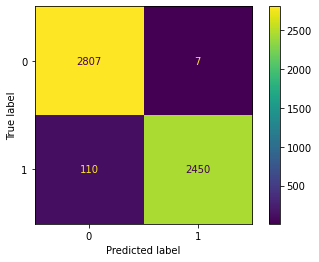

In [33]:
LR_CV = classify_pipeline(LogisticRegression(), count_vector_model)

TF-IDF Vector Model

              precision    recall  f1-score   support

           0       1.00      0.99      0.99      2814
           1       0.99      0.99      0.99      2560

    accuracy                           0.99      5374
   macro avg       0.99      0.99      0.99      5374
weighted avg       0.99      0.99      0.99      5374

Accuracy: 99.423 %
Confusion Matrix:


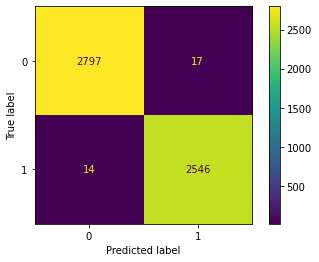

In [34]:
LR_TV = classify_pipeline(LogisticRegression(), tfidf_vector_model)

#### Decision Tree Classifier

Count Vector Model

              precision    recall  f1-score   support

           0       0.98      0.98      0.98      2814
           1       0.98      0.98      0.98      2560

    accuracy                           0.98      5374
   macro avg       0.98      0.98      0.98      5374
weighted avg       0.98      0.98      0.98      5374

Accuracy: 97.953 %
Confusion Matrix:
max_depth: 125


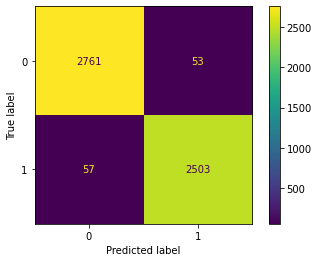

In [35]:
depth_list = [10, 50, 100, 125, 150]

optimal = None
best_acc = 0
for depth in depth_list:
  model, acc = classify_pipeline(DecisionTreeClassifier(max_depth=depth), count_vector_model, False)
  if acc > best_acc: 
    best_acc = acc
    optimal = depth

DT_CV = classify_pipeline(DecisionTreeClassifier(max_depth=optimal), count_vector_model)
print(f"max_depth: {optimal}")

TF-IDF Vector Model

              precision    recall  f1-score   support

           0       0.97      0.92      0.94      2814
           1       0.92      0.97      0.94      2560

    accuracy                           0.94      5374
   macro avg       0.94      0.94      0.94      5374
weighted avg       0.94      0.94      0.94      5374

Accuracy: 94.306 %
Confusion Matrix:
max_depth: 10


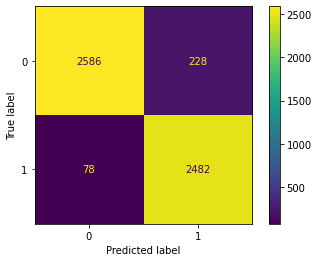

In [36]:
depth_list = [10, 50, 100, 125, 150]

optimal = None
best_acc = 0
for depth in depth_list:
  model, acc = classify_pipeline(DecisionTreeClassifier(max_depth=depth), tfidf_vector_model, False)
  if acc > best_acc: 
    best_acc = acc
    optimal = depth

DT_TV = classify_pipeline(DecisionTreeClassifier(max_depth=optimal), tfidf_vector_model)
print(f"max_depth: {optimal}")

#### Support Vector Machines Classifier

Count Vector Model

              precision    recall  f1-score   support

           0       0.94      1.00      0.97      2814
           1       1.00      0.93      0.96      2560

    accuracy                           0.96      5374
   macro avg       0.97      0.96      0.96      5374
weighted avg       0.97      0.96      0.96      5374

Accuracy: 96.464 %
Confusion Matrix:


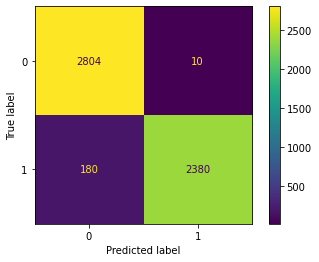

In [37]:

SVM_CV = classify_pipeline(SVC(kernel="linear"), count_vector_model)

TF-IDF Vector Model

              precision    recall  f1-score   support

           0       1.00      0.99      1.00      2814
           1       0.99      1.00      1.00      2560

    accuracy                           1.00      5374
   macro avg       1.00      1.00      1.00      5374
weighted avg       1.00      1.00      1.00      5374

Accuracy: 99.572 %
Confusion Matrix:


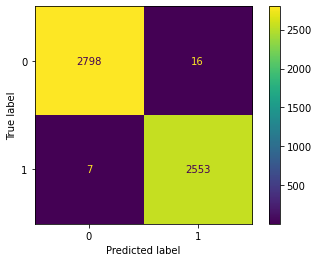

In [38]:
SVM_TV = classify_pipeline(SVC(kernel="linear"), tfidf_vector_model)

#### SVM using RBF kernel

TF-IDF Vector Model

/home/pj/.venv/dmvenv/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/pj/.venv/dmvenv/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/pj/.venv/dmvenv/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


              precision    recall  f1-score   support

           0       0.52      1.00      0.69      2814
           1       0.00      0.00      0.00      2560

    accuracy                           0.52      5374
   macro avg       0.26      0.50      0.34      5374
weighted avg       0.27      0.52      0.36      5374

Accuracy: 52.363 %
Confusion Matrix:


(SVC(), 0.5236323036844064)

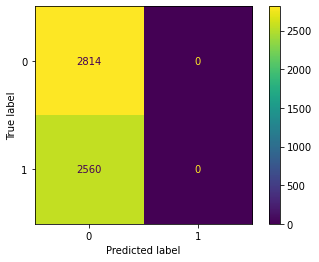

In [39]:
classify_pipeline(SVC(kernel="rbf"), tfidf_vector_model)

Count Vector Model

              precision    recall  f1-score   support

           0       1.00      0.00      0.00      2814
           1       0.48      1.00      0.65      2560

    accuracy                           0.48      5374
   macro avg       0.74      0.50      0.32      5374
weighted avg       0.75      0.48      0.31      5374

Accuracy: 47.674 %
Confusion Matrix:


(SVC(), 0.47673985857834017)

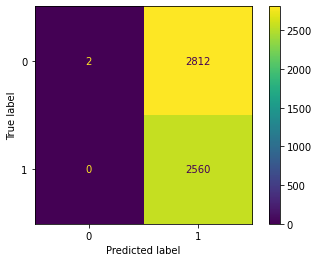

In [40]:
classify_pipeline(SVC(kernel="rbf"), count_vector_model)

#### Naive Bayes Classifier

Count Vector Model

              precision    recall  f1-score   support

           0       0.94      0.97      0.96      2814
           1       0.97      0.93      0.95      2560

    accuracy                           0.95      5374
   macro avg       0.95      0.95      0.95      5374
weighted avg       0.95      0.95      0.95      5374

Accuracy: 95.329 %
Confusion Matrix:


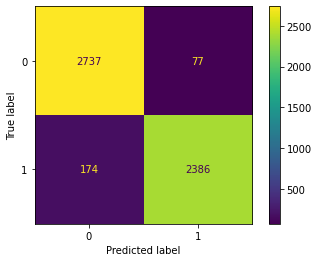

In [41]:
NB_CV = classify_pipeline(MultinomialNB(), count_vector_model)

TF-IDF Vector Model

              precision    recall  f1-score   support

           0       0.97      0.98      0.97      2814
           1       0.98      0.96      0.97      2560

    accuracy                           0.97      5374
   macro avg       0.97      0.97      0.97      5374
weighted avg       0.97      0.97      0.97      5374

Accuracy: 97.190 %
Confusion Matrix:


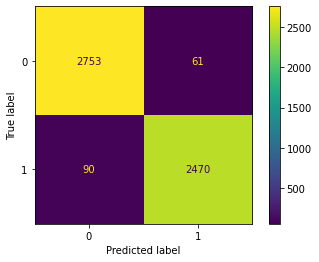

In [42]:
NB_TV = classify_pipeline(MultinomialNB(), tfidf_vector_model)

# Cross Validation

Prepare Data

In [43]:
cpy = dataset.copy()
le = LabelEncoder()
labels = le.fit_transform(cpy['label'])
cpy.drop(columns='label', inplace=True)
df = tfidf_v.transform(cpy['content'])

Perform Cross Validation

In [53]:
svm_model = SVM_TV[0]
lr_model = LR_TV[0]

In [46]:
lr_cross_score = np.average(cross_val_score(lr_model, df, labels))
svm_cross_score = np.average(cross_val_score(svm_model, df, labels))

In [47]:
print(f"Log Reg Cross Validation Score: {lr_cross_score*100:.3f}%")
print(f"SVM Cross Validation Score: {svm_cross_score*100:.3f}%")

Log Reg Cross Validation Score: 98.381%
SVM Cross Validation Score: 99.006%


# DEMO

In [48]:
demo_df = pd.read_csv('Data/fake_or_real_news.csv')

In [49]:
def getRandomText():
  text_length = 0
  while text_length < 2000:
    rand = np.random.randint(0, demo_df.shape[0])
    text = demo_df.iloc[rand]['text']
    text_length = len(text)
  return demo_df.iloc[rand]['text'], demo_df.iloc[rand]['label']

Get Random Text

In [50]:
random_text, label = getRandomText()
print(f"Length: {len(random_text)}")
print(f'Random Text: {random_text}\nLabel: {label}')

Length: 115372
Random Text: Why Are So Many People Choosing To Leave The United States Permanently?   August 11th, 2013 
Have things gotten so bad that it is time to leave the United States for good? That is a question that a lot of Americans are dealing with these days, and an increasing number of them are choosing to leave the country of their birth permanently. Some are doing it for tax reasons, some are doing it because they believe the future is brighter elsewhere, and others are doing it because they are very distressed about the direction that America is heading and they don’t see any hope for a turnaround any time soon. Personally, I have several friends and contacts that regard themselves as “preppers” that have decided that the United States is too far gone to recover. They have moved their families out of the country and they never plan to return. As this nation continues to head down the very troubled road that it is currently on, this trend is probably only going to accele

Transform/Normalize Text and Classify

In [54]:
def transform_classify(text):
  wl = WordNetLemmatizer()
  words = text.split()
  lem = [wl.lemmatize(word) for word in words if not word in STOPWORDS] # Remove stop words and replace word with stem
  text_lem = ' '.join(lem)  # Combine back into sentence

  transformed_text = tfidf_v.transform([text_lem])     

  lr_pred = lr_model.predict(transformed_text)
  svm_pred = svm_model.predict(transformed_text)

  def results(pred):
    if pred == 1:
      return 'REAL'
    else: return 'FAKE'

  print(f'Logistic Regression: {results(lr_pred)}')
  print(f'SVM: {results(svm_pred)}')

transform_classify(random_text)

Logistic Regression: FAKE
SVM: FAKE
